In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
import torchinfo

import matplotlib.pyplot as plt
import numpy as np
from typing import *
import gc
import random

from ShanghaiTechPartA.partA import PartADataset

## Auto-Encoder

This is a baseline model for this project. It consists of 3 layers of convolutional layers in the encoder, 
and 3 layers of convolution transpose layers in the decoder. In addition, there are 2 1x1 convolution layers 
serve as fully connected nodes. After the auto-encoder, the model should output a heatmap as the input y value.

After many testing with different parameter, we found out the model is not suitable for high resolution images.
The optimal resolution for them would be 128 x 128. When testing with 512 x 512 or 1024 x 1024, the model's output
is completely off. To deal with that, I tried to add 1 more layer to both the encoder and decoder. However, the VRAM
usage for that increased to 20 GB, which I deicded to stop.

Learning rate adjustion is also the essential part of this training. I started out with a typical 0.01 LR. The output 
quickly becomes all zeros within 1 epoch. I would imagine it is because the target heatmap contains mostly 0s with only
relatively small amounts of 1s for head. After a series of testing, I finally decide an optimal LR for this model would
be 0.0000001, which could provide a descent output.

When looking at losses for each batch trained, I found out the losses between images with many crowds and a few crowds 
varies a lot when using the MSE. I think that is because it is getting the squared difference per pixel, which if the 
target's sum is small the loss will be smaller, and the target's sum is big, the loss will be bigger. So I decided to 
create my own custom loss function. Instead of dividing the number of pixel, I decided to divide the sum of target, which 
is the number of heads presented on the image. To keep the division in a reasonable range, I applied the log to it. It turned
out the losses for each batch does not bounce up and down too much.

As the output turns out, the model cannot really understand what is a face/human. It is just extracting every features of 
the image and convert it to dots. For example, in one of the sample, the model thinks there are multiple people in the sky,
which is just branches of the tree. For crowd counting, I think it requires a more featured model to handle this task.

In [44]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 2, padding=1) 
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32,  64, 2, padding=1) 
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 2, padding=1)    
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 2, padding=1)  
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, 2)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.convt = nn.ConvTranspose2d(512,  256, 2, padding=1)
        self.conv1t = nn.ConvTranspose2d(256, 128, 2, padding=1) 
        self.conv2t = nn.ConvTranspose2d(128,  64, 2, padding=1) 
        self.conv3t = nn.ConvTranspose2d( 64,  32, 2, padding=1) 
        self.conv4t = nn.ConvTranspose2d( 32,   1, 2, padding=1) 
        self.drop = nn.Dropout(1./4.)
        
        self.conv = nn.Conv2d(256, 256, 1)
        self.convO = nn.Conv2d(1, 1, 1)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
#         x = F.relu(self.bn5(self.conv5(x)))

        x = self.conv(x)
        
#         x = F.relu(self.convt(x))
        x = F.relu(self.conv1t(x))
        x = F.relu(self.conv2t(x))
        x = F.relu(self.conv3t(x))
        x = F.relu(self.conv4t(x))
        
        x = self.convO(x)
        
        return x
        

In [3]:
DEVICE = torch.device("cuda:1")
DEVICE

device(type='cuda', index=1)

In [95]:
def train(
    net: nn.Module,
    train_data: torch.utils.data.DataLoader,
    val_data: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_function: Any,
    epochs: int,
    device: torch.device
) -> Tuple[list, list]:

    all_batch_loss = []
    all_valid_loss = []

    for epoch in range(epochs):
        batch_loss = .0
        valid_loss = .0

        net.train()
        for batch_idx, (data, target) in enumerate(train_data):

            data, target = data.to(device), target.to(device)

            out = net(data)
#             if out.sum() == 0: return [-1],[-1]
#             print(out)
#             return [-1],[-1]
#             print(out.sum(), target.sum(), end=' ')
            loss = loss_function(out, target)
            # loss.requires_grad = True
#             print(loss.item())
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

            batch_loss += loss.item()
        all_batch_loss.append(batch_loss / 4)

        net.eval()
        for data, target in val_data:
            data, target = data.to(device), target.to(device)
            
            out = net(data)
            loss = loss_function(out, target)
            valid_loss += loss.item()

        all_valid_loss.append(valid_loss / 4)
        
        print(
            f"Epoch {epoch + 1} / {epochs}: "
            f"TLoss {batch_loss / len(train_data)}, "
            f"VLoss {valid_loss / len(val_data)}"
        )
        
    return all_batch_loss, all_valid_loss

In [5]:
def draw_losses(train_loss, valid_loss):
    plt.plot(train_loss, label="Training Loss")
    plt.plot(valid_loss, label="Validation Loss")
    plt.legend()
    plt.show()

In [102]:
import math
def customLoss(out, target):
    return torch.sum(torch.square(torch.sub(torch.abs(out), target)))/math.log(torch.sum(target))

In [104]:
cnn = CNN().to(DEVICE)
loss_func = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(cnn.parameters(), lr=0.0000001)

In [89]:
transform_d = transforms.Compose([transforms.Resize(128), transforms.CenterCrop(128)])
# , guassian=transforms.GaussianBlur(7, (7, 7))
train_data = PartADataset("part_A/train_data/images", "part_A/train_data/ground-truth", transform=transform_d)
val_data   = PartADataset("part_A/test_data/images", "part_A/test_data/ground-truth", transform=transform_d)
train_data = DataLoader(train_data, batch_size=4, shuffle=False)
val_data = DataLoader(val_data, batch_size=4, shuffle=False)


In [82]:
torchinfo.summary(cnn, input_size=(1, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 1, 128, 128]          1,050,368
├─Conv2d: 1-1                            [1, 32, 129, 129]         416
├─BatchNorm2d: 1-2                       [1, 32, 129, 129]         64
├─Conv2d: 1-3                            [1, 64, 130, 130]         8,256
├─BatchNorm2d: 1-4                       [1, 64, 130, 130]         128
├─Conv2d: 1-5                            [1, 128, 131, 131]        32,896
├─BatchNorm2d: 1-6                       [1, 128, 131, 131]        256
├─Conv2d: 1-7                            [1, 256, 132, 132]        131,328
├─BatchNorm2d: 1-8                       [1, 256, 132, 132]        512
├─Conv2d: 1-9                            [1, 256, 132, 132]        65,792
├─ConvTranspose2d: 1-10                  [1, 128, 131, 131]        131,200
├─ConvTranspose2d: 1-11                  [1, 64, 130, 130]         32,832
├─ConvTranspose2d: 1-12                  [1, 32, 

In [10]:
for batch_idx, (data, target) in enumerate(train_data):
    print(data.shape)
    print(target.sum())
    if batch_idx > 1:
        break

torch.Size([1, 3, 128, 128])
tensor(150.)
torch.Size([1, 3, 128, 128])
tensor(62.)
torch.Size([1, 3, 128, 128])
tensor(37.)


In [11]:
torch.cuda.memory_summary(device=DEVICE, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 1                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    5470 KB |    5470 KB |    5470 KB |       0 B  |\n|       from large pool |    4096 KB |    4096 KB |    4096 KB |       0 B  |\n|       from small pool |    1374 KB |    1374 KB |    1374 KB |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |    5470 KB |    5470 KB |    5470 KB |       0 B  |\n|       from large pool |    4096 KB |    4096 KB |

In [12]:
!nvidia-smi

Thu Dec  1 19:47:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:5E:00.0 Off |                  N/A |
| 40%   30C    P8     3W / 280W |   4416MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:86:00.0 Off |                  N/A |
| 42%   

Epoch 1 / 20: TLoss 84.72442850748698, VLoss 76.74745319200599
Epoch 2 / 20: TLoss 79.4407692972819, VLoss 74.6381134364916
Epoch 3 / 20: TLoss 75.29790715535482, VLoss 70.40207232599673
Epoch 4 / 20: TLoss 72.03412979125977, VLoss 67.04200176570727
Epoch 5 / 20: TLoss 69.43504104614257, VLoss 64.3484239578247
Epoch 6 / 20: TLoss 67.34243927001953, VLoss 62.16546668177066
Epoch 7 / 20: TLoss 65.64059443155925, VLoss 60.37936426245648
Epoch 8 / 20: TLoss 64.24297505696615, VLoss 58.906752959541656
Epoch 9 / 20: TLoss 63.08673543294271, VLoss 57.68095418681269
Epoch 10 / 20: TLoss 62.12170855204264, VLoss 56.65170980536419
Epoch 11 / 20: TLoss 61.31018928527832, VLoss 55.781715766243316
Epoch 12 / 20: TLoss 60.62350952148437, VLoss 55.04195607226828
Epoch 13 / 20: TLoss 60.0379293568929, VLoss 54.40873000932776
Epoch 14 / 20: TLoss 59.53598007202149, VLoss 53.863834878672726
Epoch 15 / 20: TLoss 59.10339434305827, VLoss 53.39179812306943
Epoch 16 / 20: TLoss 58.72757624308268, VLoss 52.9

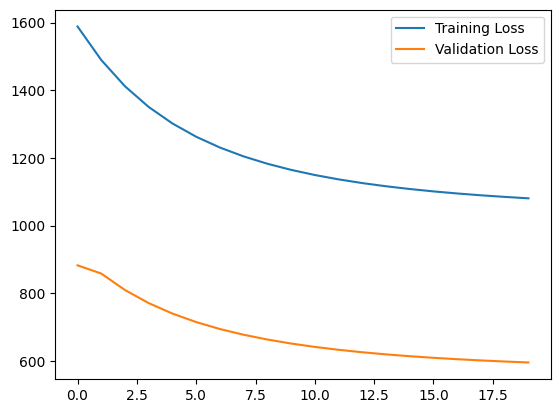

In [105]:
torch.cuda.empty_cache()
gc.collect()

draw_losses(*train(cnn, train_data, val_data, optimizer, customLoss, 20, DEVICE))

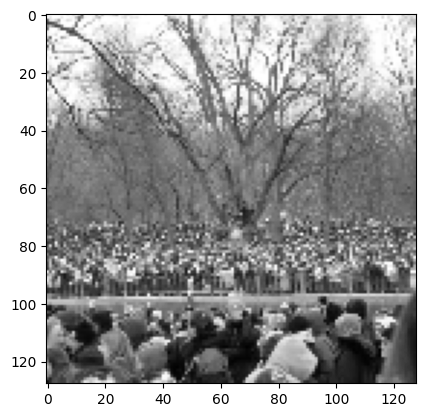

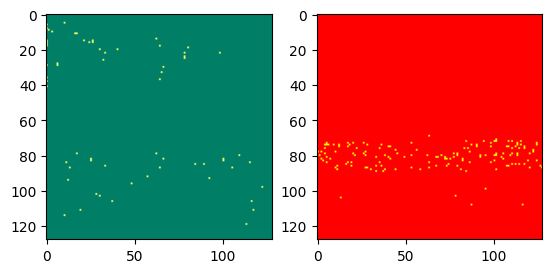

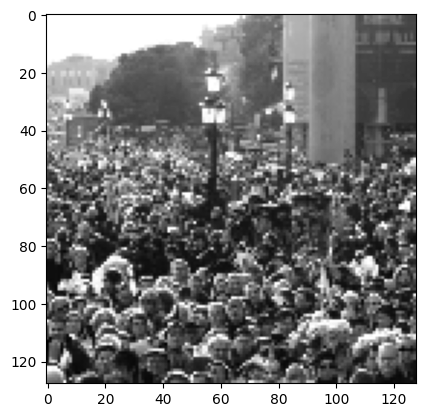

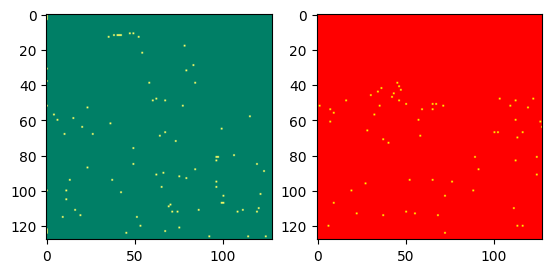

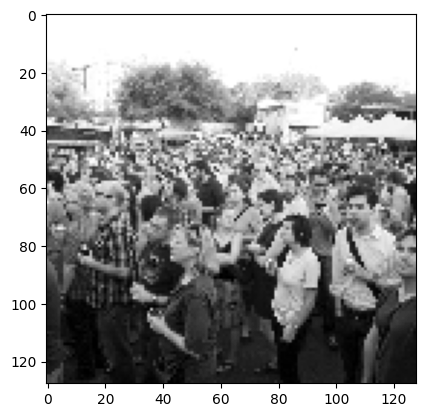

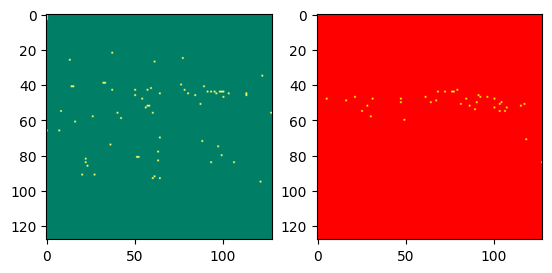

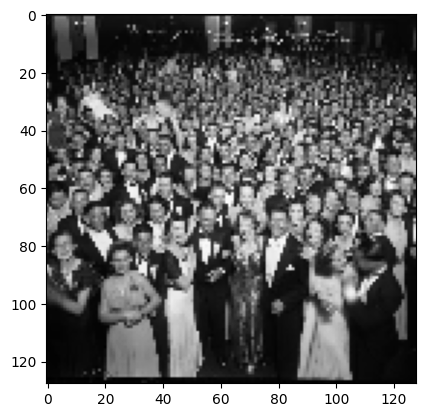

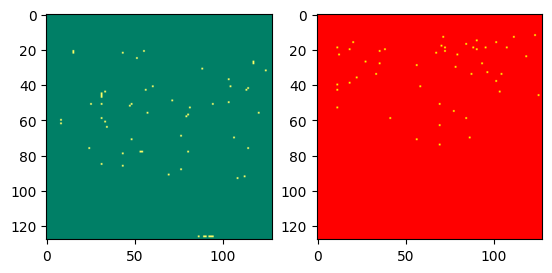

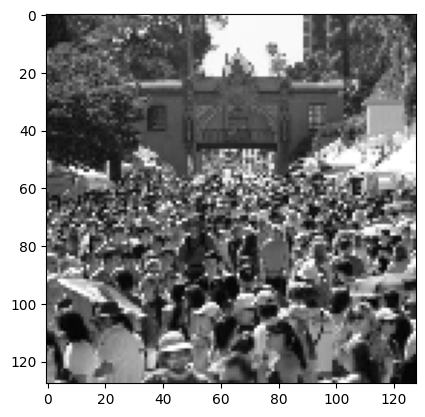

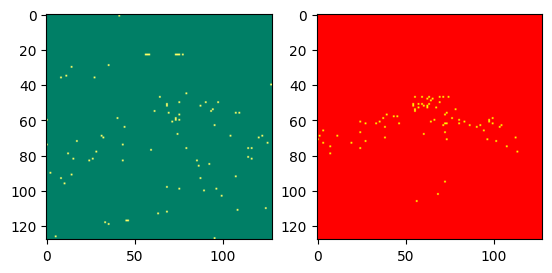

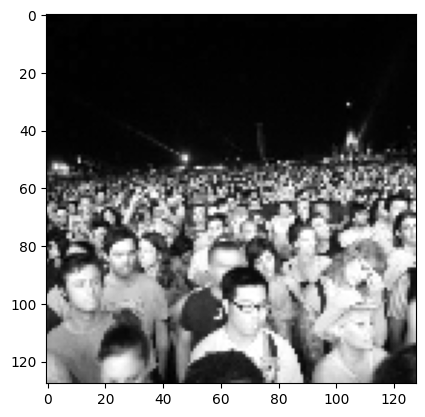

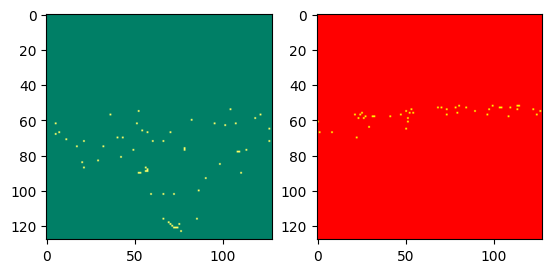

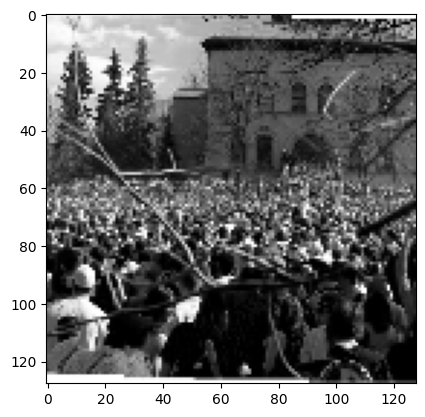

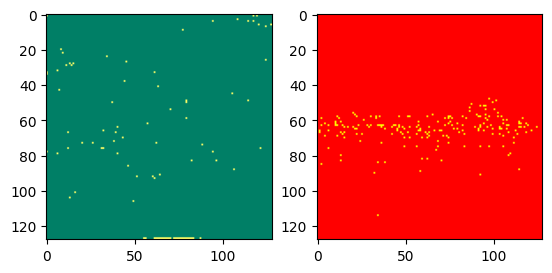

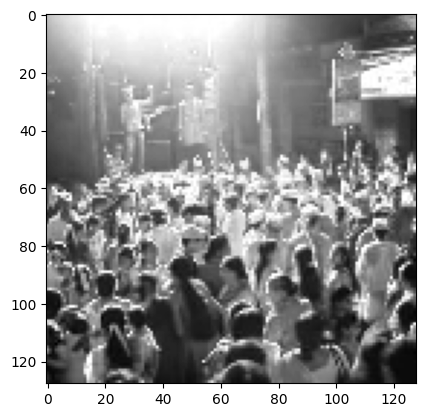

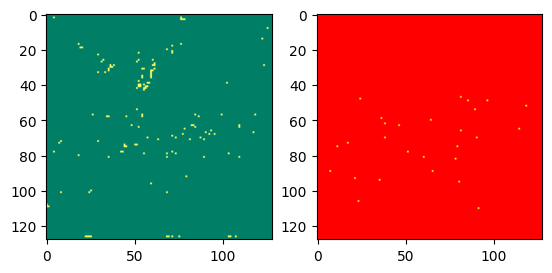

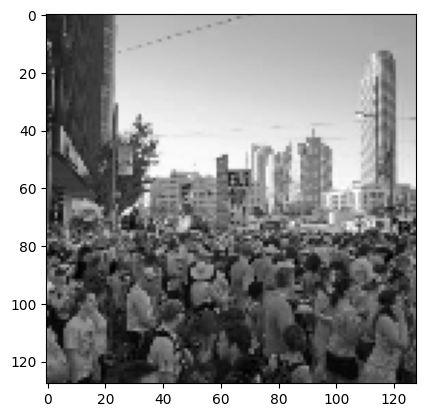

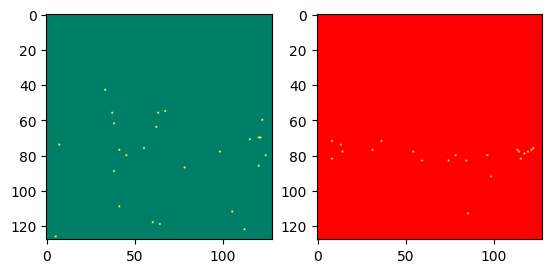

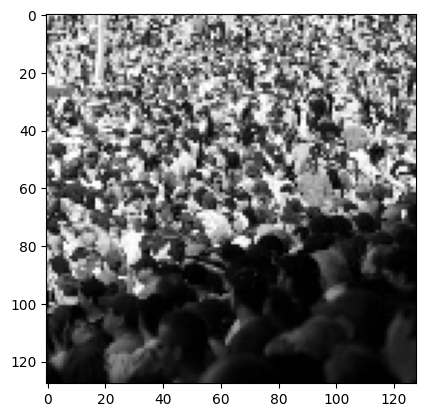

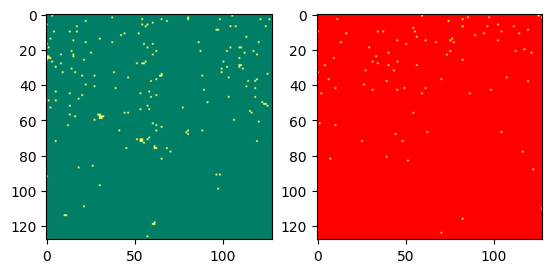

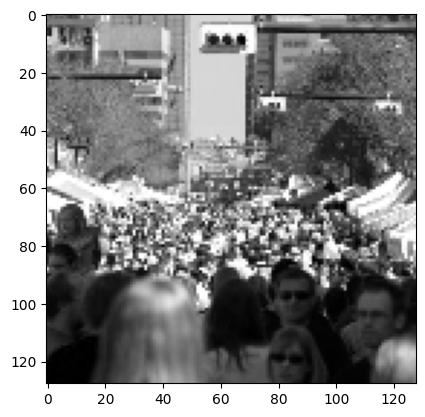

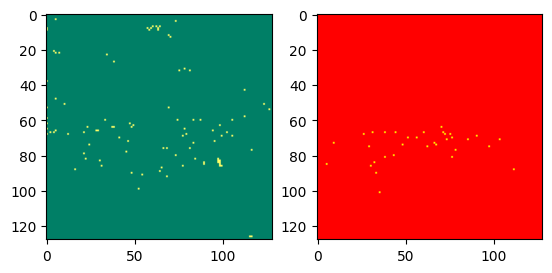

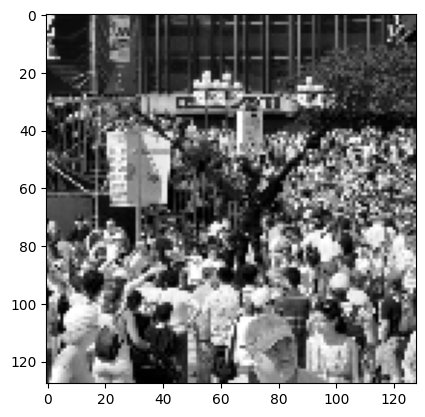

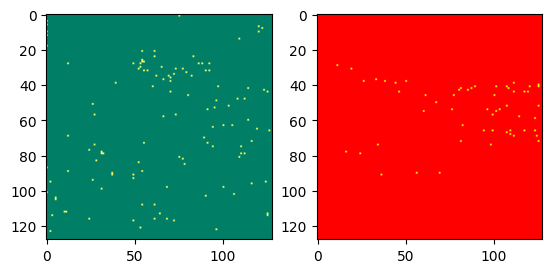

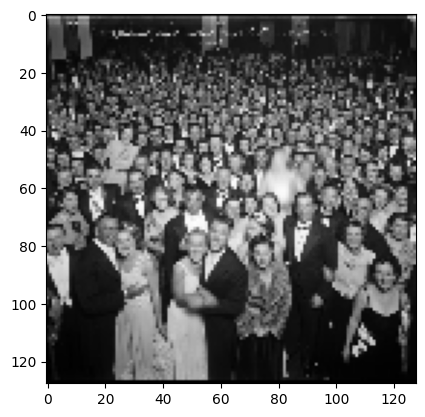

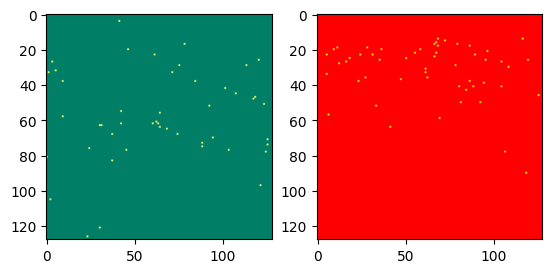

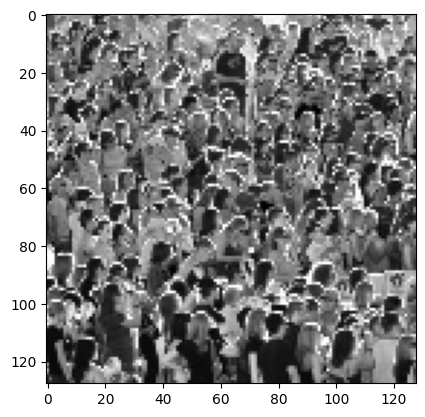

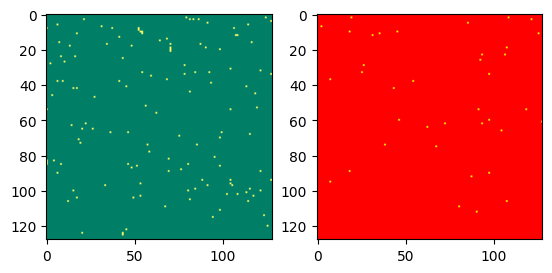

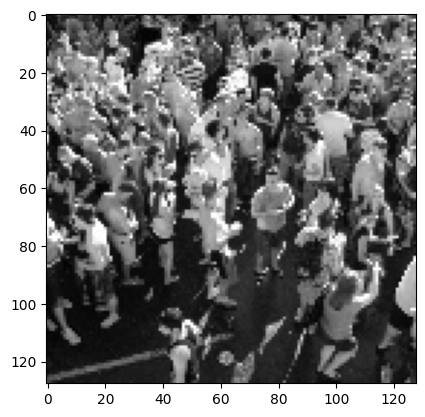

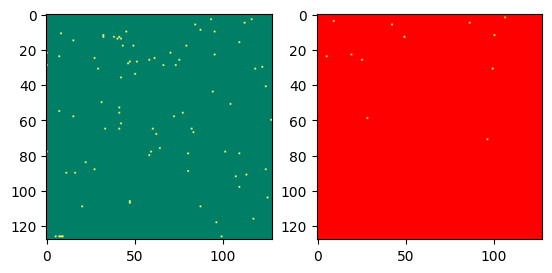

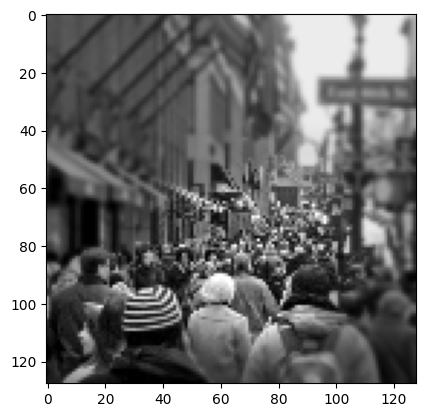

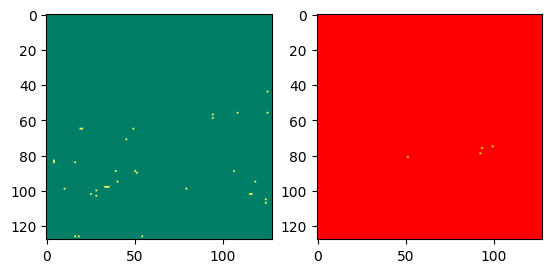

torch.Size([4, 1, 128, 128])

In [108]:
for batch_idx, (data, target) in enumerate(train_data):
    pred = cnn(data.to(DEVICE))
    t = target
    for i in range(pred.shape[0]):
        proc = pred[i].cpu().detach()
        proc = transforms.Lambda(lambda x: torch.where(abs(x) > 0.1, 1.0, 0.0))(proc)
        plt.imshow(data[i][0].reshape(128, 128), cmap='gray')
        plt.show()
        _, ax = plt.subplots(1,2)
        ax[0].imshow(proc.reshape(128, 128), cmap='summer')
        ax[1].imshow(t[i].reshape(128, 128), cmap='autumn')
        plt.show()
    if batch_idx >2:
        break

pred.shape

In [15]:
pred.sum()

tensor(10.4174, device='cuda:1', grad_fn=<SumBackward0>)

In [16]:
t.sum()

tensor(53.)

In [17]:
t.shape

torch.Size([1, 1, 128, 128])

In [18]:
torch.sum(torch.abs(torch.sub(pred[i].cpu(), t[i])))

tensor(63.4174, grad_fn=<SumBackward0>)